In [1]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import pandas as pd
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control
import random

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Ejemplo 1

Dada una señal de entrada y salida (archivo TCLAB), obtenga el modelo estimado usando el modelo ARMAX.
Valide el modelo obtenido usando otro grupo de datos distinto

**Paso 1: Lectura de los datos**

,t,y,u,y1,y2,y3,u1,u2,u3,one
0,0,23.585442,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,23.023559,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,24.283600,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,23.747457,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,24.524536,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
596,596,51.017172,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
597,597,51.309833,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
598,598,52.486418,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
599,599,51.603644,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


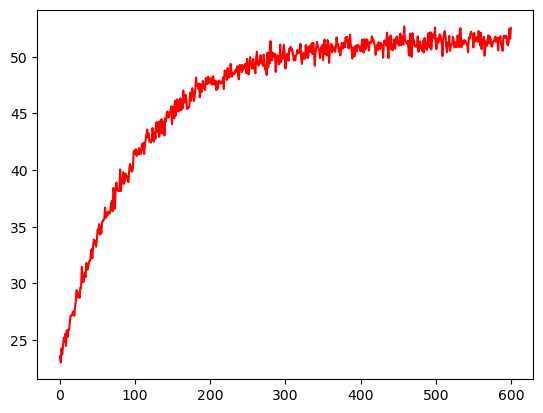

In [5]:
data1 = pd.read_csv ('data\TCLab_PWM_50.csv')
N = len(data1.Tiempo)
u = np.ones(N)*6
empty = np.zeros(N)

df1 = pd.DataFrame(data={'t':data1.Tiempo,'y':data1.Temperatura,'u':u,'y1':empty,'y2':empty,'y3':empty,'u1':empty,'u2':empty,'u3':empty,'one':np.ones(N)})
plt.plot(df1.t,df1.y,color = 'red')
dt = (df1.t[1]-df1.t[0])/1.0
df1

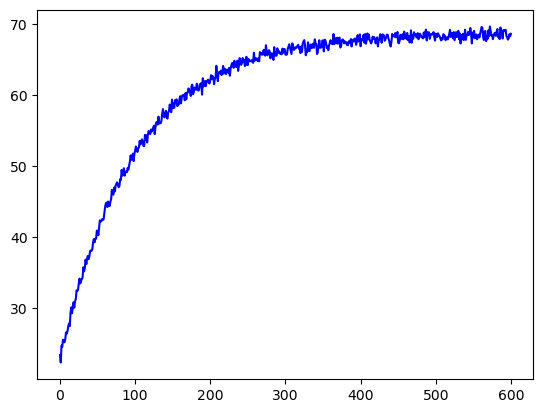

In [6]:
data2 = pd.read_csv ('data\TCLab_PWM_80.csv')
u = np.ones(N)*9.6
df2 = pd.DataFrame(data={'t':data2.Tiempo,'y':data2.Temperatura,'u':u,'y1':empty,'y2':empty,'y3':empty,'u1':empty,'u2':empty,'u3':empty,'one':np.ones(N)})
plt.plot(df2.t,df2.y,color = 'blue')


## Definiendo la matriz de regresión

**Paso 2:** Proponer el regresor de la estimación ARX y calcular los parámetros $\theta$ de la estimación ARX, para este ejemplo se propone:

$$\phi = [-y[k-1],-y[k-2],-y[k-3],u[k-1],u[k-2],u[k-3]]$$

In [7]:
## Definir y_1, y_2, dependiendo el sistema que se quiera modelar, 
## así como u_1, u_2 y las que se requieran
df1.y1 = df1.y.shift(1)
df1.y2 = df1.y.shift(2)
df1.y3 = df1.y.shift(3)

df1.u1 = df1.u.shift(1)
df1.u2 = df1.u.shift(2)
df1.u3 = df1.u.shift(3)
df1 = df1.fillna(0)


,t,y,u,y1,y2,y3,u1,u2,u3,one
0,0,23.585442,6.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
1,1,23.023559,6.0,23.585442,0.000000,0.000000,6.0,0.0,0.0,1.0
2,2,24.283600,6.0,23.023559,23.585442,0.000000,6.0,6.0,0.0,1.0
3,3,23.747457,6.0,24.283600,23.023559,23.585442,6.0,6.0,6.0,1.0
4,4,24.524536,6.0,23.747457,24.283600,23.023559,6.0,6.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...
596,596,51.017172,6.0,51.143194,51.861849,51.810924,6.0,6.0,6.0,1.0
597,597,51.309833,6.0,51.017172,51.143194,51.861849,6.0,6.0,6.0,1.0
598,598,52.486418,6.0,51.309833,51.017172,51.143194,6.0,6.0,6.0,1.0
599,599,51.603644,6.0,52.486418,51.309833,51.017172,6.0,6.0,6.0,1.0


In [26]:
## Creación del vector phi
phi = np.array([df1.y1,df1.y2,df1.y3,df1.u1,df1.u2]).transpose()

# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.
A = np.dot(phi.T,phi)
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,df1.y))
theta

array([ 0.4466129 ,  0.43820165,  0.09472957,  2.08166606, -1.90843759])

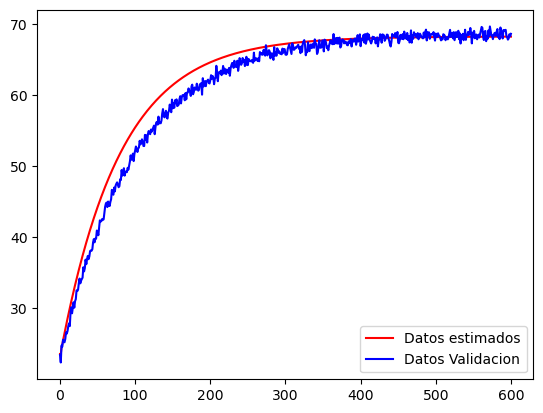

In [38]:
## reconstruyendo la estimación
### Modelo 
### y_e = -y_1,-y_2,u_1
ye1 = np.zeros(N)

for k in range(2,N):
    ye1[k] = theta[0]*ye1[k-1]+theta[1]*ye1[k-2]+theta[2]*ye1[k-3]+theta[3]*df2.u[k-1]+theta[4]*df2.u[k-2]

ye1 = 0.55*ye1 + 23.58
plt.plot(df2.t,ye1,color = 'red')
plt.plot(df2.t,df2.y,color = 'blue')
plt.legend(["Datos estimados", "Datos Validacion"])



## Calculando la respuesta al step de la estimación

**Paso 4:** Calculamos la respuesta de la función $G_e$ y con esos datos determinamos el error de la estimación inicial.

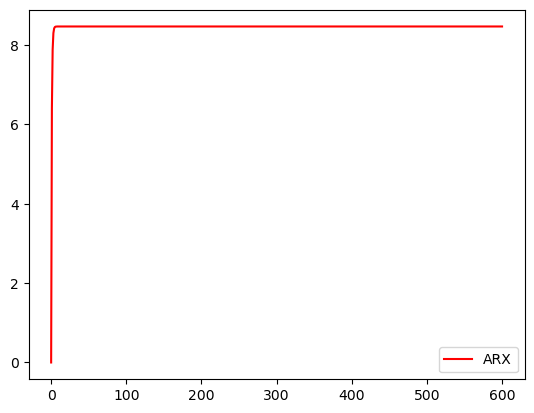

In [41]:
## SIN EL DATO DE TIEMPO ES COMPLEJO
## Función de transferencia

G_e = control.tf([theta[3],theta[4],0],[1,-theta[0],-theta[1],-theta[2]],dt/100)

## Definiendo la función de transferencia estimada ARX
_,ye = control.step_response(G_e,df1.t)
## Ganancia de ajuste 

## Señal de error estimado
#e = df2.y-ye

plt.plot(df1.t,ye,color = 'red')
#plt.plot(df2.t,df2.y,color = 'black')
#plt.plot(df2.t,e,color = 'blue')
plt.legend(['ARX','Datos medidos','Error'])